### Student Information
Name: 張仲穎

Student ID: 110062599

GitHub ID: cyc310224

Kaggle name: seed1214

Kaggle private scoreboard snapshot:

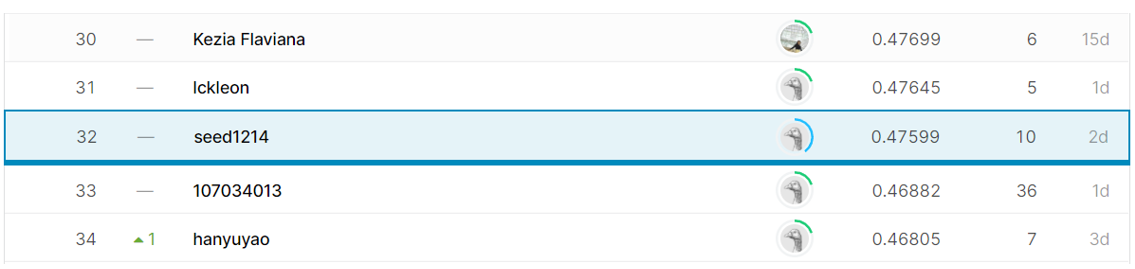

---

In [1]:
import json
import nlp
import pandas as pd
import tensorflow as tf
%matplotlib inline
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

2022-01-05 11:19:13.493898: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


### Limiting GPU Memory

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 9000)])

2022-01-05 11:19:14.113386: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-01-05 11:19:14.133594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-05 11:19:14.134199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2022-01-05 11:19:14.134219: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-01-05 11:19:14.136642: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-01-05 11:19:14.136666: I tensorflow/stream_executor/platform/

### Training Data

In [3]:
file = open("tweets_DM.json", 'r', encoding='utf-8')
papers = []
for line in file.readlines():
    dic = json.loads(line)
    papers.append(dic)
df = pd.DataFrame.from_dict(pd.json_normalize(papers), orient='columns')
df

,_score,_index,_crawldate,_type,_source.tweet.hashtags,_source.tweet.tweet_id,_source.tweet.text
0,391,hashtag_tweets,2015-05-23 11:42:47,tweets,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,433,hashtag_tweets,2016-01-28 04:52:09,tweets,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,232,hashtag_tweets,2017-12-25 04:39:20,tweets,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k..."
3,376,hashtag_tweets,2016-01-24 23:53:05,tweets,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,989,hashtag_tweets,2016-01-08 17:18:59,tweets,[],0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...,...,...,...,...,...
1867530,827,hashtag_tweets,2015-05-12 12:51:52,tweets,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...
1867531,368,hashtag_tweets,2017-10-02 17:54:04,tweets,[],0x29d0cb,I swear all this hard work gone pay off one da...
1867532,498,hashtag_tweets,2016-10-10 11:04:32,tweets,[],0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,840,hashtag_tweets,2016-09-02 14:25:06,tweets,[],0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [4]:
df = df.set_axis(['score', 'index', 'crawldate', 'type', 'hashtag', 'tweet_id', 'tweet_text'], axis=1)
df = df.drop(columns=['score', 'index', 'crawldate', 'type', 'hashtag'])
df

,tweet_id,tweet_text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,I swear all this hard work gone pay off one da...
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [5]:
df_emotion = pd.read_csv("./emotion.csv") 
df_emotion

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation
...,...,...
1455558,0x38dba0,joy
1455559,0x300ea2,joy
1455560,0x360b99,fear
1455561,0x22eecf,joy


In [6]:
df_concat=pd.merge(df, df_emotion, on='tweet_id')
df_concat

,tweet_id,tweet_text,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",sadness
2,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
3,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,joy
4,0x2c91a8,Still waiting on those supplies Liscus. <LH>,anticipation
...,...,...,...
1455558,0x321566,I'm SO HAPPY!!! #NoWonder the name of this sho...,joy
1455559,0x38959e,In every circumtance I'd like to be thankful t...,joy
1455560,0x2cbca6,there's currently two girls walking around the...,joy
1455561,0x24faed,"Ah, corporate life, where you can date <LH> us...",joy


### Validation Data Split
I do the validation with test_size = 0.1, and record the epoch when early stop.  
Then, I use all data as training data to train the model again(with epoch number I recorded).  
The model performs better after increasing the dataset.  

In [9]:
train_X, val_X, train_y, val_y = train_test_split(df_concat['tweet_text'], df_concat['emotion'], test_size=0.1)

In [74]:
train_X = df_concat['tweet_text']
train_y = df_concat['emotion']

In [77]:
tweets = list(train_X)
labels = list(train_y)

In [78]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(tweets)
print(tokenizer.texts_to_sequences([tweets[3]]))

[[1, 1, 1675, 9, 3, 109, 62, 174, 34, 1504, 1, 2, 4835, 1, 53]]


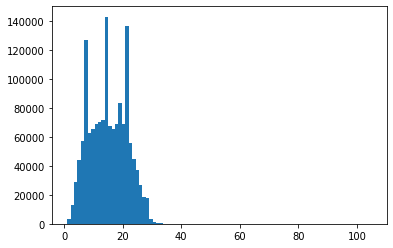

In [80]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [81]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=40, padding='post')
    return padded_sequences

In [82]:
padded_train_sequences = get_sequences(tokenizer, tweets)
padded_train_sequences[3]

array([   1,    1, 1675,    9,    3,  109,   62,  174,   34, 1504,    1,
          2, 4835,    1,   53,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

{'disgust', 'joy', 'sadness', 'trust', 'anticipation', 'surprise', 'fear', 'anger'}


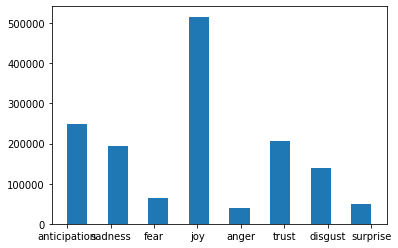

In [83]:
classes = set(labels)
print(classes)
plt.hist(labels, bins=15)
plt.show()

In [84]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())
classes_to_index

{'disgust': 0,
 'joy': 1,
 'sadness': 2,
 'trust': 3,
 'anticipation': 4,
 'surprise': 5,
 'fear': 6,
 'anger': 7}

In [85]:
index_to_classes

{0: 'disgust',
 1: 'joy',
 2: 'sadness',
 3: 'trust',
 4: 'anticipation',
 5: 'surprise',
 6: 'fear',
 7: 'anger'}

In [86]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [87]:
train_labels = names_to_ids(labels)

4


(1455563,)

In [88]:
# val_tweets = list(val_X)
# val_labels = list(val_y)
# val_sequences = get_sequences(tokenizer, val_tweets)
# val_labels = names_to_ids(val_labels)

In [89]:
# val_tweets[0], val_labels[0]

In [105]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=40),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(20)),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 16)            160000    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 40, 40)            4560      
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 40)                7440      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 328       
Total params: 172,328
Trainable params: 172,328
Non-trainable params: 0
_________________________________________________________________


In [106]:
history = model.fit(
    padded_train_sequences, train_labels,
#     validation_data=(val_sequences, val_labels),
    epochs=8,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
#     ]
)

Epoch 1/8
45487/45487 [==============================] - 194s 4ms/step - loss: 1.2476 - accuracy: 0.5511
Epoch 2/8
45487/45487 [==============================] - 191s 4ms/step - loss: 1.1458 - accuracy: 0.5874
Epoch 3/8
45487/45487 [==============================] - 192s 4ms/step - loss: 1.1181 - accuracy: 0.5973
Epoch 4/8
45487/45487 [==============================] - 192s 4ms/step - loss: 1.1029 - accuracy: 0.6026
Epoch 5/8
45487/45487 [==============================] - 192s 4ms/step - loss: 1.0931 - accuracy: 0.6069
Epoch 6/8
45487/45487 [==============================] - 192s 4ms/step - loss: 1.0859 - accuracy: 0.6093
Epoch 7/8
45487/45487 [==============================] - 192s 4ms/step - loss: 1.0807 - accuracy: 0.6113
Epoch 8/8
45487/45487 [==============================] - 192s 4ms/step - loss: 1.0780 - accuracy: 0.6123


### Ploting Accuracy Curve and Loss Curve

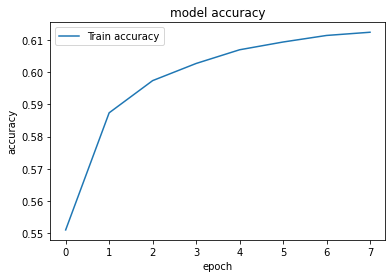

In [107]:
# Answer here
# summarize history for accuracy
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['Train accuracy', 'Val accuracy'], loc='upper left')
plt.legend(['Train accuracy'], loc='upper left')
plt.show()

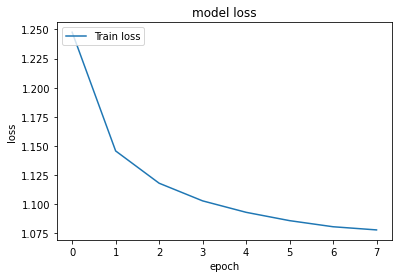

In [108]:
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['Train loss', 'Val loss'], loc='upper left')
plt.legend(['Train loss'], loc='upper left')
plt.show()

### Testing Data

In [109]:
df_identification = pd.read_csv("./data_identification.csv") 

In [110]:
df_test=pd.merge(df, df_identification, on='tweet_id')
df_test

,tweet_id,tweet_text,identification
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train
2,0x28b412,"Confident of your obedience, I write to you, k...",test
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train
4,0x2de201,"""Trust is not the same as faith. A friend is s...",test
...,...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,test
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,test
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,test
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us...",train


In [111]:
df_test = df_test[df_test["identification"]=="test"]
df_test.reset_index(drop=True, inplace=True)
df_test = df_test.drop(columns=["identification"])
df_test

,tweet_id,tweet_text
0,0x28b412,"Confident of your obedience, I write to you, k..."
1,0x2de201,"""Trust is not the same as faith. A friend is s..."
2,0x218443,When do you have enough ? When are you satisfi...
3,0x2939d5,"God woke you up, now chase the day #GodsPlan #..."
4,0x26289a,"In these tough times, who do YOU turn to as yo..."
...,...,...
411967,0x2913b4,"""For this is the message that ye heard from th..."
411968,0x2a980e,"""There is a lad here, which hath five barley l..."
411969,0x316b80,When you buy the last 2 tickets remaining for ...
411970,0x29d0cb,I swear all this hard work gone pay off one da...


### Name to ID (Testing)

In [112]:
test_tweets = list(df_test['tweet_text'])
test_sequences = get_sequences(tokenizer, test_tweets)

### Predict on Testing Data

In [114]:
predict_y = model.predict_classes(test_sequences)
predict_y

/home/hsnl-iot/anaconda3/envs/seedenv/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([4, 4, 1, ..., 2, 0, 2])

In [115]:
ids_to_names = lambda labels: np.array([index_to_classes.get(x) for x in labels])

In [116]:
result_df = ids_to_names(predict_y)
result_df

array(['anticipation', 'anticipation', 'joy', ..., 'sadness', 'disgust',
       'sadness'], dtype='<U12')

In [117]:
result_df = pd.DataFrame(result_df)
result_df

,0
0,anticipation
1,anticipation
2,joy
3,joy
4,trust
...,...
411967,anticipation
411968,anticipation
411969,sadness
411970,disgust


In [118]:
result_df = pd.concat([df_test['tweet_id'], result_df], axis=1)
result_df.columns = ['id','emotion']
result_df

,id,emotion
0,0x28b412,anticipation
1,0x2de201,anticipation
2,0x218443,joy
3,0x2939d5,joy
4,0x26289a,trust
...,...,...
411967,0x2913b4,anticipation
411968,0x2a980e,anticipation
411969,0x316b80,sadness
411970,0x29d0cb,disgust


### Output CSV

In [119]:
result_df.to_csv("./DM_GRU4.csv", index=False)

## Report
I use the model with an embedding layer, two bidirectional GRU layers, and two dense layers.  
I have tried to use some preprocessing method like remove stop words, symbols, and punctuation.  
However, the acccuracy goes down when I do the above preprocessing, so I only use tokenizer in the end.  

In [3]:
# from nltk.corpus import stopwords
# from nltk import RegexpTokenizer
# tokenizer = RegexpTokenizer("[\w']+")
# filt = '[!"#$%&()*,-./:;<=>?@[\]^_`{|}~ ]'

# train_df['split'] = train_df['text'] .apply(lambda x: x.replace("<LH>",""))
# train_df['split'] = train_df['split'].apply(lambda x: re.sub(filt, ' ', x.lower()))
# train_df['split'] = train_df['split'].apply(lambda x: re.sub(r'\d+', " ", x))
# train_df['split'] = train_df['split'].apply(lambda x: re.sub('<[^<]+?>', " ", x))
# train_df['split'] = train_df['split'].apply(lambda x: x.split(" "))

# test_df['split'] = test_df['text'] .apply(lambda x: x.replace("<LH>",""))
# test_df['split'] = test_df['split'].apply(lambda x: re.sub(filt, ' ', x.lower()))
# test_df['split'] = test_df['split'].apply(lambda x: re.sub(r'\d+', " ", x))
# test_df['split'] = test_df['split'].apply(lambda x: re.sub('<[^<]+?>', " ", x))
# test_df['split'] = test_df['split'].apply(lambda x: x.split(" "))

# stop_words = set(stopwords.words('english'))
# train_df['no_stopwords'] = train_df['split'].apply(lambda x: [item for item in x if item not in stop_words])
# train_df['no_stopwords'] = train_df['no_stopwords'].apply(lambda x: [item for item in x if len(item) > 1])
# test_df['no_stopwords'] = test_df['split'].apply(lambda x: [item for item in x if item not in stop_words])
# test_df['no_stopwords'] = test_df['no_stopwords'].apply(lambda x: [item for item in x if len(item) > 1])
# porter = nltk.stem.PorterStemmer()
# lemmatizer = WordNetLemmatizer() 

# train_df['stemmed'] = train_df['no_stopwords'].apply(lambda x: [porter.stem(y) for y in x])
# test_df['stemmed'] = test_df['no_stopwords'].apply(lambda x: [porter.stem(y) for y in x])
# train_df['lemmatization'] = train_df['no_stopwords'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
# test_df['lemmatization'] = test_df['no_stopwords'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
# train_df['lem_ste'] = train_df['lemmatization'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
# test_df['lem_ste'] = test_df['lemmatization'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

# train_df['clean'] = train_df['lem_ste'].apply(lambda x: [item for item in x if not item.isnumeric() ])
# test_df['clean'] = test_df['lem_ste'].apply(lambda x: [item for item in x if not item.isnumeric() ])
# train_df['cleaned'] = train_df['clean'].apply(' '.join)
# test_df['cleaned'] = test_df['clean'].apply(' '.join)


At first, I use ML method (BOW and Random forest), and I get 0.31 score in the public leaderboard.  
Then I use the DL method that TA used in Lab2-Homework, and I get 0.41 score in the public leaderboard.  
In the end, I use RNN-based model architecture to achieve the 0.47 score in the public leaderboard.  
I used to replace GRU to LSTM in my final model. However, the accuracy is quitely close.  
And I also add the one dense layer to my final model, this do improve model's accuracy.  

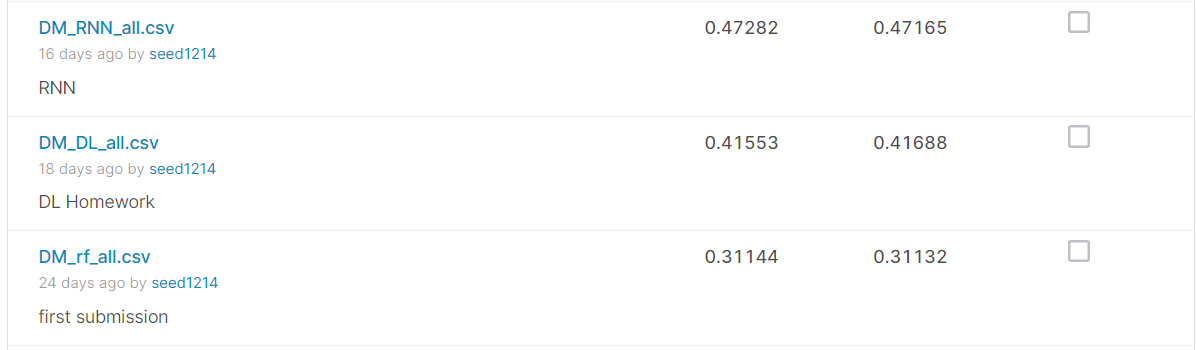

I'll put all my notebooks(ML, DL, RNN) under the "notebook" dictionary.  
So TAs can check the methods I had tried.  